<a href="https://colab.research.google.com/github/NickMuhigi/Time-Series-Forecasting/blob/main/air_quality_forecasting_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

Imports and setup

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional, Input, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
import os
import datetime
from tabulate import tabulate

For reproducibility

In [172]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

Mount Google Drive

In [173]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Data

In [175]:
train_path = '/content/drive/MyDrive/train.csv'
test_path = '/content/drive/MyDrive/test.csv'
sample_path = '/content/drive/MyDrive/sample_submission .csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample = pd.read_csv(sample_path)

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [176]:
print("Training Data Shape:", train.shape)
print("Test Data Shape:", test.shape)
print("Columns:", list(train.columns))
display(train.head())
display(train.describe(include='all').T)

Training Data Shape: (30676, 12)
Test Data Shape: (13148, 11)
Columns: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
No,30676.0,NaN,NaN,NaN,15338.5,8855.542765,1.0,7669.75,15338.5,23007.25,30676.0
DEWP,30676.0,NaN,NaN,NaN,-0.029431,0.994087,-2.135153,-0.888034,-0.056622,0.913358,1.814055
TEMP,30676.0,NaN,NaN,NaN,-0.062712,1.015193,-2.57807,-0.938521,0.045209,0.864984,2.340578
PRES,30676.0,NaN,NaN,NaN,0.013612,1.008991,-2.380821,-0.82267,-0.043595,0.832865,2.877939
Iws,30676.0,NaN,NaN,NaN,0.030542,1.018337,-0.468688,-0.441894,-0.352512,0.005216,11.231956
Is,30676.0,NaN,NaN,NaN,0.016992,1.087278,-0.069353,-0.069353,-0.069353,-0.069353,35.439859
Ir,30676.0,NaN,NaN,NaN,0.011253,1.063811,-0.137667,-0.137667,-0.137667,-0.137667,25.288745
datetime,30676,30676,2013-07-02 03:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cbwd_NW,30676.0,NaN,NaN,NaN,0.016193,1.006001,-0.690542,-0.690542,-0.690542,1.448138,1.448138
cbwd_SE,30676.0,NaN,NaN,NaN,0.005833,1.001847,-0.732019,-0.732019,-0.732019,1.366085,1.366085


Visual quick check of pm2.5 distribution

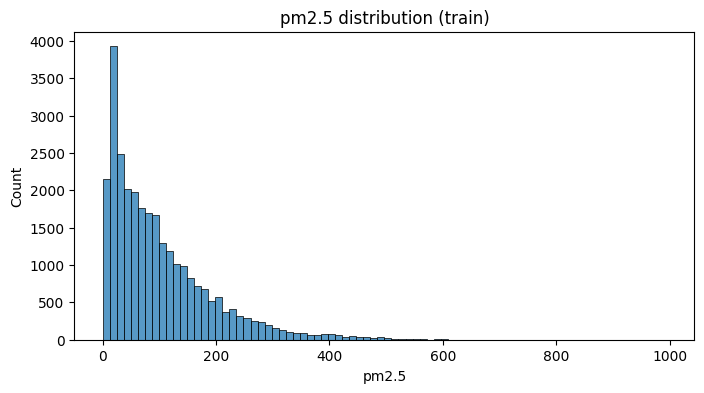

In [177]:
plt.figure(figsize=(8,4))
sns.histplot(train['pm2.5'].dropna(), bins=80, kde=False)
plt.title("pm2.5 distribution (train)")
plt.xlabel("pm2.5")
plt.show()

Check missing values

In [178]:
print("Missing values (train):")
print(train.isna().sum())
print("\nMissing values (test):")
print(test.isna().sum())

Missing values (train):
No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64

Missing values (test):
No          0
DEWP        0
TEMP        0
PRES        0
Iws         0
Is          0
Ir          0
datetime    0
cbwd_NW     0
cbwd_SE     0
cbwd_cv     0
dtype: int64


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

Basic forward/backfill

In [179]:
train.fillna(method='ffill', inplace=True)
train.fillna(method='bfill', inplace=True)
test.fillna(method='ffill', inplace=True)
test.fillna(method='bfill', inplace=True)

/tmp/ipython-input-3405811957.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill', inplace=True)
/tmp/ipython-input-3405811957.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='bfill', inplace=True)
/tmp/ipython-input-3405811957.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='ffill', inplace=True)
/tmp/ipython-input-3405811957.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='bfill', inplace=True)


If 'No' column exists (some starters include it), drop it

In [180]:
for df in [train, test]:
    if 'No' in df.columns:
        df.drop(columns=['No'], inplace=True)

If datetime-like columns exist, parse them. Otherwise, attempt to create a sequential index

In [181]:
if 'date' in train.columns:
    train['date'] = pd.to_datetime(train['date'])
    test['date'] = pd.to_datetime(test['date'])
else:
    train_length = len(train)
    start = datetime.datetime(2010,1,1,0,0)
    train['date'] = pd.date_range(start, periods=train_length, freq='H')
    test['date'] = pd.date_range(train['date'].iloc[-1] + pd.Timedelta(hours=1),
                                 periods=len(test), freq='H')

/tmp/ipython-input-3511329835.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  train['date'] = pd.date_range(start, periods=train_length, freq='H')
/tmp/ipython-input-3511329835.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test['date'] = pd.date_range(train['date'].iloc[-1] + pd.Timedelta(hours=1),


Feature engineering

In [182]:
def add_time_features(df):
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    return df

train = add_time_features(train)
test = add_time_features(test)

Rolling and lag features for variables likely to be predictive

In [188]:
rolling_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'pm2.5']
lag_hours = [1,2,3,6,12,24]

for col in ['DEWP','TEMP','PRES','Iws']:
    for lag in lag_hours:
        train[f'{col}_lag{lag}'] = train[col].shift(lag)
        test[f'{col}_lag{lag}'] = test[col].shift(lag)
    train[f'{col}_roll3'] = train[col].rolling(3, min_periods=1).mean()
    train[f'{col}_roll24'] = train[col].rolling(24, min_periods=1).mean()
    test[f'{col}_roll3'] = test[col].rolling(3, min_periods=1).mean()
    test[f'{col}_roll24'] = test[col].rolling(24, min_periods=1).mean()

for lag in lag_hours:
    train[f'pm2.5_lag{lag}'] = train['pm2.5'].shift(lag)

train['pm2.5_roll3'] = train['pm2.5'].rolling(3, min_periods=1).mean()
train['pm2.5_roll24'] = train['pm2.5'].rolling(24, min_periods=1).mean()

train.fillna(method='bfill', inplace=True)
test.fillna(method='bfill', inplace=True)

/tmp/ipython-input-288191598.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='bfill', inplace=True)
/tmp/ipython-input-288191598.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='bfill', inplace=True)


Backfill newly created NaNs

In [189]:
train.fillna(method='bfill', inplace=True)
test.fillna(method='bfill', inplace=True)

/tmp/ipython-input-3736888924.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='bfill', inplace=True)
/tmp/ipython-input-3736888924.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='bfill', inplace=True)


Drop columns that are non-numeric or not useful

In [190]:
non_feature_cols = ['date']
for c in non_feature_cols:
    if c in train.columns:
        train.drop(columns=[c], inplace=True)
    if c in test.columns:
        test.drop(columns=[c], inplace=True)

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [191]:
y = train['pm2.5'].values.reshape(-1,1)
X = train.drop(columns=['pm2.5'])

Select numeric columns

In [192]:
X_numeric = X.select_dtypes(include=['float64','int64']).copy()
X_test_numeric = test.select_dtypes(include=['float64','int64']).copy()

Drop pm2.5 lag/roll columns for modeling

In [193]:
drop_cols = [col for col in X_numeric.columns if 'pm2.5_lag' in col or 'pm2.5_roll' in col]
X_numeric = X_numeric.drop(columns=drop_cols, errors='ignore')
X_test_numeric = X_test_numeric.drop(columns=drop_cols, errors='ignore')

Add missing columns in test to match train

In [194]:
missing_cols = set(X_numeric.columns) - set(X_test_numeric.columns)
for c in missing_cols:
    X_test_numeric[c] = 0

Align column order

In [195]:
X_test_numeric = X_test_numeric[X_numeric.columns]

Scale features and target

In [196]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_numeric)
y_scaled = scaler_y.fit_transform(y)
X_test_scaled = scaler_X.transform(X_test_numeric)

Create sequences

In [197]:
def create_sequences(X, y, seq_len=24):
    Xs, ys = [], []
    for i in range(len(X)-seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

def create_test_sequences_for_submission(X_all_scaled, seq_len=24):
    n_total = X_all_scaled.shape[0]
    sequences = []
    test_start = len(X_scaled)
    for idx in range(test_start, n_total):
        start_idx = idx - seq_len
        if start_idx < 0:
            seq = X_all_scaled[0:seq_len]
        else:
            seq = X_all_scaled[start_idx:idx]
        sequences.append(seq)
    return np.array(sequences)

Attention Layer

In [198]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)
    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [201]:
def build_hybrid_model(input_shape, units=128, dropout=0.3, lr=0.001, bidirectional=True):
    inp = Input(shape=input_shape)
    x = inp
    if bidirectional:
        x = Bidirectional(LSTM(units, return_sequences=True))(x)
    else:
        x = LSTM(units, return_sequences=True)(x)
    x = Dropout(dropout)(x)
    x = GRU(units//2, return_sequences=True)(x)
    x = Dropout(dropout)(x)
    x = Attention()(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(1)(x)
    model = Model(inputs=inp, outputs=out)
    # Change lr -> learning_rate
    model.compile(optimizer=Adam(learning_rate=lr, clipnorm=1.0),
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    return model

Experiment table

In [202]:
experiment_grid = [
    {'seq_len':24, 'units':128, 'dropout':0.3, 'lr':0.001, 'batch_size':64},
    {'seq_len':48, 'units':128, 'dropout':0.3, 'lr':0.001, 'batch_size':64},
    {'seq_len':72, 'units':128, 'dropout':0.3, 'lr':0.001, 'batch_size':64},
]

experiment_results = []
best_model = None
best_val_rmse = np.inf
best_config = None

for i, cfg in enumerate(experiment_grid):
    print(f"\n--- Experiment {i+1} ---")
    seq_len = cfg['seq_len']
    units = cfg['units']
    dropout = cfg['dropout']
    lr = cfg['lr']
    batch_size = cfg['batch_size']
    epochs = 60

    X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len=seq_len)
    val_split = int(0.8 * len(X_seq))
    X_tr, X_val = X_seq[:val_split], X_seq[val_split:]
    y_tr, y_val = y_seq[:val_split], y_seq[val_split:]

    model = build_hybrid_model(input_shape=(seq_len, X_seq.shape[2]),
                               units=units, dropout=dropout, lr=lr)
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    ]
    history = model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=callbacks, verbose=1)

    val_metrics = model.evaluate(X_val, y_val, verbose=0)
    val_rmse = val_metrics[1]

    train_preds_scaled = model.predict(X_tr)
    train_rmse = np.sqrt(np.mean((y_tr.flatten()-train_preds_scaled.flatten())**2))

    print(f"Experiment {i+1} — val_rmse: {val_rmse:.4f}, train_rmse: {train_rmse:.4f}")

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_model = model
        best_config = cfg


--- Experiment 1 ---
Epoch 1/60
384/384 ━━━━━━━━━━━━━━━━━━━━ 70s 158ms/step - loss: 0.0093 - rmse: 0.0934 - val_loss: 0.0076 - val_rmse: 0.0872 - learning_rate: 0.0010
Epoch 2/60
384/384 ━━━━━━━━━━━━━━━━━━━━ 61s 159ms/step - loss: 0.0048 - rmse: 0.0696 - val_loss: 0.0064 - val_rmse: 0.0802 - learning_rate: 0.0010
Epoch 3/60
384/384 ━━━━━━━━━━━━━━━━━━━━ 80s 154ms/step - loss: 0.0043 - rmse: 0.0655 - val_loss: 0.0064 - val_rmse: 0.0799 - learning_rate: 0.0010
Epoch 4/60
384/384 ━━━━━━━━━━━━━━━━━━━━ 61s 158ms/step - loss: 0.0041 - rmse: 0.0642 - val_loss: 0.0064 - val_rmse: 0.0802 - learning_rate: 0.0010
Epoch 5/60
384/384 ━━━━━━━━━━━━━━━━━━━━ 85s 167ms/step - loss: 0.0039 - rmse: 0.0622 - val_loss: 0.0068 - val_rmse: 0.0824 - learning_rate: 0.0010
Epoch 6/60
384/384 ━━━━━━━━━━━━━━━━━━━━ 60s 155ms/step - loss: 0.0036 - rmse: 0.0598 - val_loss: 0.0065 - val_rmse: 0.0808 - learning_rate: 0.0010
Epoch 7/60
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0034 - rmse: 0.0584
Epoch 7: Red

Final Prediction

In [203]:
X_all_scaled = np.vstack([X_scaled, X_test_scaled])
SEQ_LEN = best_config['seq_len']
X_test_seq_for_pred = create_test_sequences_for_submission(X_all_scaled, seq_len=SEQ_LEN)
preds_scaled = best_model.predict(X_test_seq_for_pred)
preds = scaler_y.inverse_transform(preds_scaled.reshape(-1,1)).flatten()

411/411 ━━━━━━━━━━━━━━━━━━━━ 45s 109ms/step


Adjust prediction length

In [204]:
if len(preds) > len(sample):
    preds = preds[:len(sample)]
elif len(preds) < len(sample):
    pad_len = len(sample) - len(preds)
    preds = np.concatenate([preds, np.repeat(preds[-1], pad_len)])

submission = sample.copy()
submission['pm2.5'] = preds
submission.to_csv('/content/drive/MyDrive/2-updated_submission.csv', index=False)
print("Submission saved.")

Submission saved.


Plot last training history

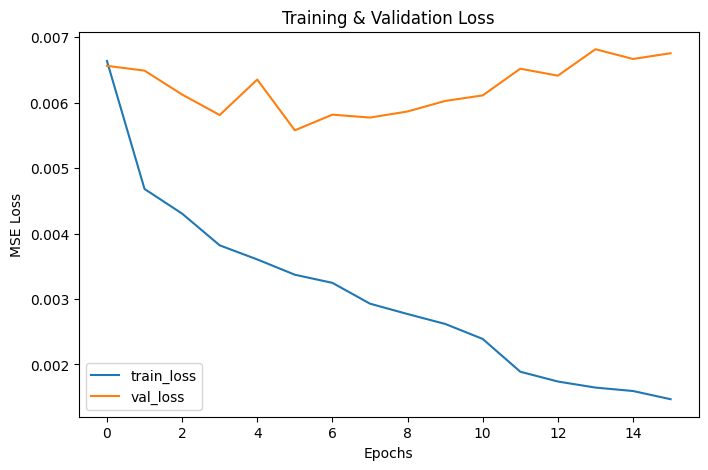

In [205]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

Quick RMSE on last validation

In [206]:
val_preds_scaled = best_model.predict(X_val)
val_preds = scaler_y.inverse_transform(val_preds_scaled)
y_val_true = scaler_y.inverse_transform(y_val)
val_rmse_abs = np.sqrt(np.mean((y_val_true.flatten() - val_preds.flatten())**2))
print(f"Last experiment validation RMSE (absolute scale): {val_rmse_abs:.4f}")

192/192 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step
Last experiment validation RMSE (absolute scale): 74.2224
